In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')

# Closed Loop forecasting on Dpp mutant embryos

## Collect timing information

Dpp_Mutants/Sqh-GFP/202307141520
Dpp_Mutants/Sqh-GFP/202307141345
Dpp_Mutants/Sqh-GFP/202307132230
Dpp_Controls/Sqh-GFP/202307131330
Dpp_Controls/Sqh-GFP/202307131720


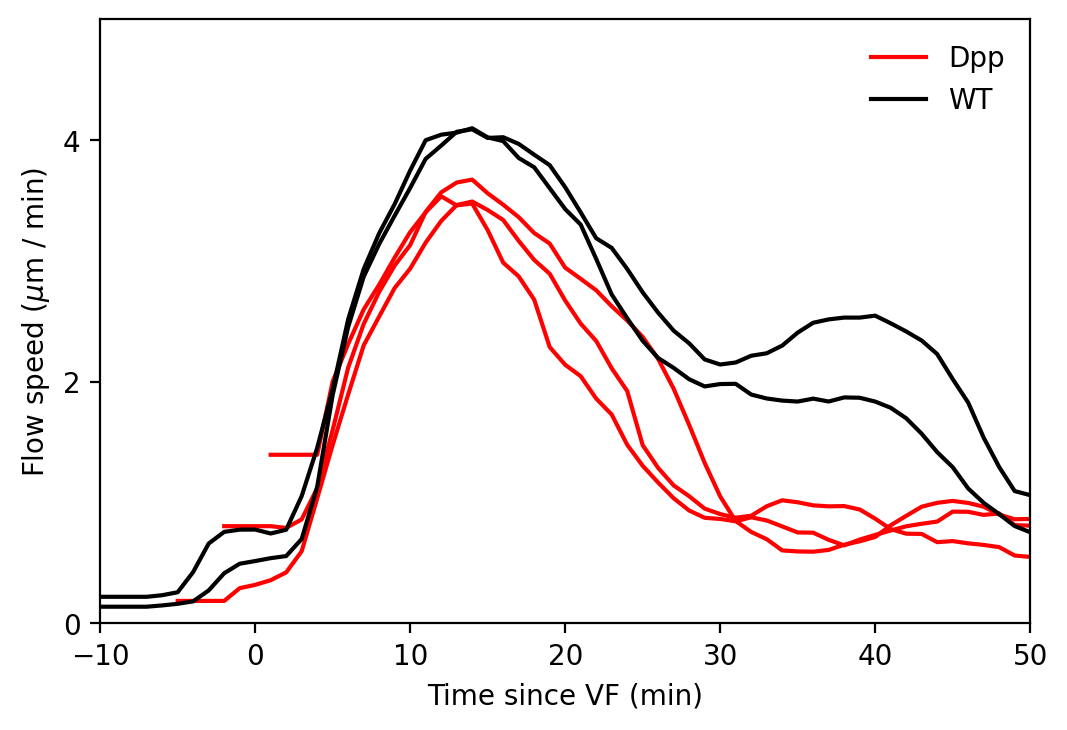

In [18]:
import glob
offsets_dpp = {
    '202307132230': 5,
    '202307141345': -1,
    '202307141520': 2,
    '202307131330': 10,
    '202307131720': 10,
}
    
fig, ax = plt.subplots(1, 1, dpi=200)
for i, folder in enumerate(glob.glob('Dpp_Mutants/Sqh-GFP/202*')):
    print(folder)
    eId = os.path.basename(folder)
    v0 = np.load(f'{folder}/velocity2D.npy', mmap_mode='r')
    t = np.arange(len(v0)) - offsets_dpp[eId]

    if i == 0:
        ax.plot(t, np.linalg.norm(v0, axis=1).mean(axis=(1, 2)), color='red', label='Dpp' )
    else:
        ax.plot(t, np.linalg.norm(v0, axis=1).mean(axis=(1, 2)), color='red')        

for i, folder in enumerate(glob.glob('Dpp_Controls/Sqh-GFP/202*')):
    print(folder)
    eId = os.path.basename(folder)
    v0 = np.load(f'{folder}/velocity2D.npy', mmap_mode='r')
    t  = np.arange(len(v0)) - offsets_dpp[eId]

    if i == 0:
        ax.plot(t, np.linalg.norm(v0, axis=1).mean(axis=(1, 2)), color='black', label='WT' )
    else:
        ax.plot(t, np.linalg.norm(v0, axis=1).mean(axis=(1, 2)), color='black')

        
ax.set_ylim([0, 5])
ax.set_yticks([0, 2, 4])
ax.set_xlim([-10, 50])
ax.set_ylabel('Flow speed ($\mu$m / min)')
ax.set_xlabel('Time since VF (min)')
ax.legend(framealpha=0)

In [101]:
t = np.arange(0, 41)

v_dpp_avg = np.zeros(len(t))
v_dpp_std = np.zeros(len(t))
v_wt_avg = np.zeros(len(t))
v_wt_std = np.zeros(len(t))

for i, ti in enumerate(t):
    vi = []
    for folder in glob.glob('Dpp_Mutants/Sqh-GFP/202*'):
        eId = os.path.basename(folder)
        v0 = np.linalg.norm(np.load(f'{folder}/velocity2D.npy', mmap_mode='r'), axis=1).mean(axis=(1,2))
        t0 = np.arange(len(v0)) - offsets_dpp[eId]            
        vi.append(v0[np.abs(t0 - ti) < 1])
    vi = np.concatenate(vi)
    v_dpp_avg[i] = np.mean(vi)
    v_dpp_std[i] = np.std(vi)
    
    vi = []
    for folder in glob.glob('Dpp_Controls/Sqh-GFP/202*'):
        eId = os.path.basename(folder)
        v0 = np.linalg.norm(np.load(f'{folder}/velocity2D.npy', mmap_mode='r'), axis=1).mean(axis=(1,2))
        t0 = np.arange(len(v0)) - offsets_dpp[eId]        
        vi.append(v0[np.abs(t0 - ti) < 1])
    vi = np.concatenate(vi)
    v_wt_avg[i] = np.mean(vi)
    v_wt_std[i] = np.std(vi)

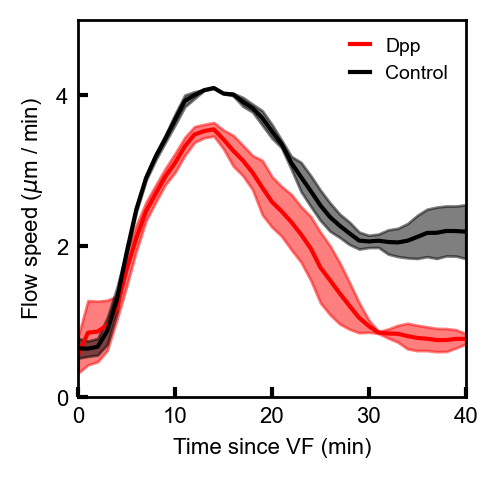

In [103]:
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(2.5, 2.5))

ax.plot(t, v_dpp_avg, color='red', label='Dpp')
ax.fill_between(t, v_dpp_avg-v_dpp_std, v_dpp_avg+v_dpp_std, color='red', alpha=0.5)

ax.plot(t, v_wt_avg, color='black', label='Control')
ax.fill_between(t, v_wt_avg-v_wt_std, v_wt_avg+v_wt_std, color='black', alpha=0.5)
        
ax.set_ylim([0, 5])
ax.set_yticks([0, 2, 4])
ax.set_xlim([0, 40])
ax.set_ylabel('Flow speed ($\mu$m / min)')
ax.set_xlabel('Time since VF (min)')
ax.tick_params(which='both', direction='in')
ax.legend(framealpha=0)

## Get cadherin initial condition

0.693, 2.48, 1.31, 0.38
0.665, 2.8, 1.68, 0.491
0.671, 2.18, 1.37, 0.32
0.68, 2.18, 1.35, 0.297


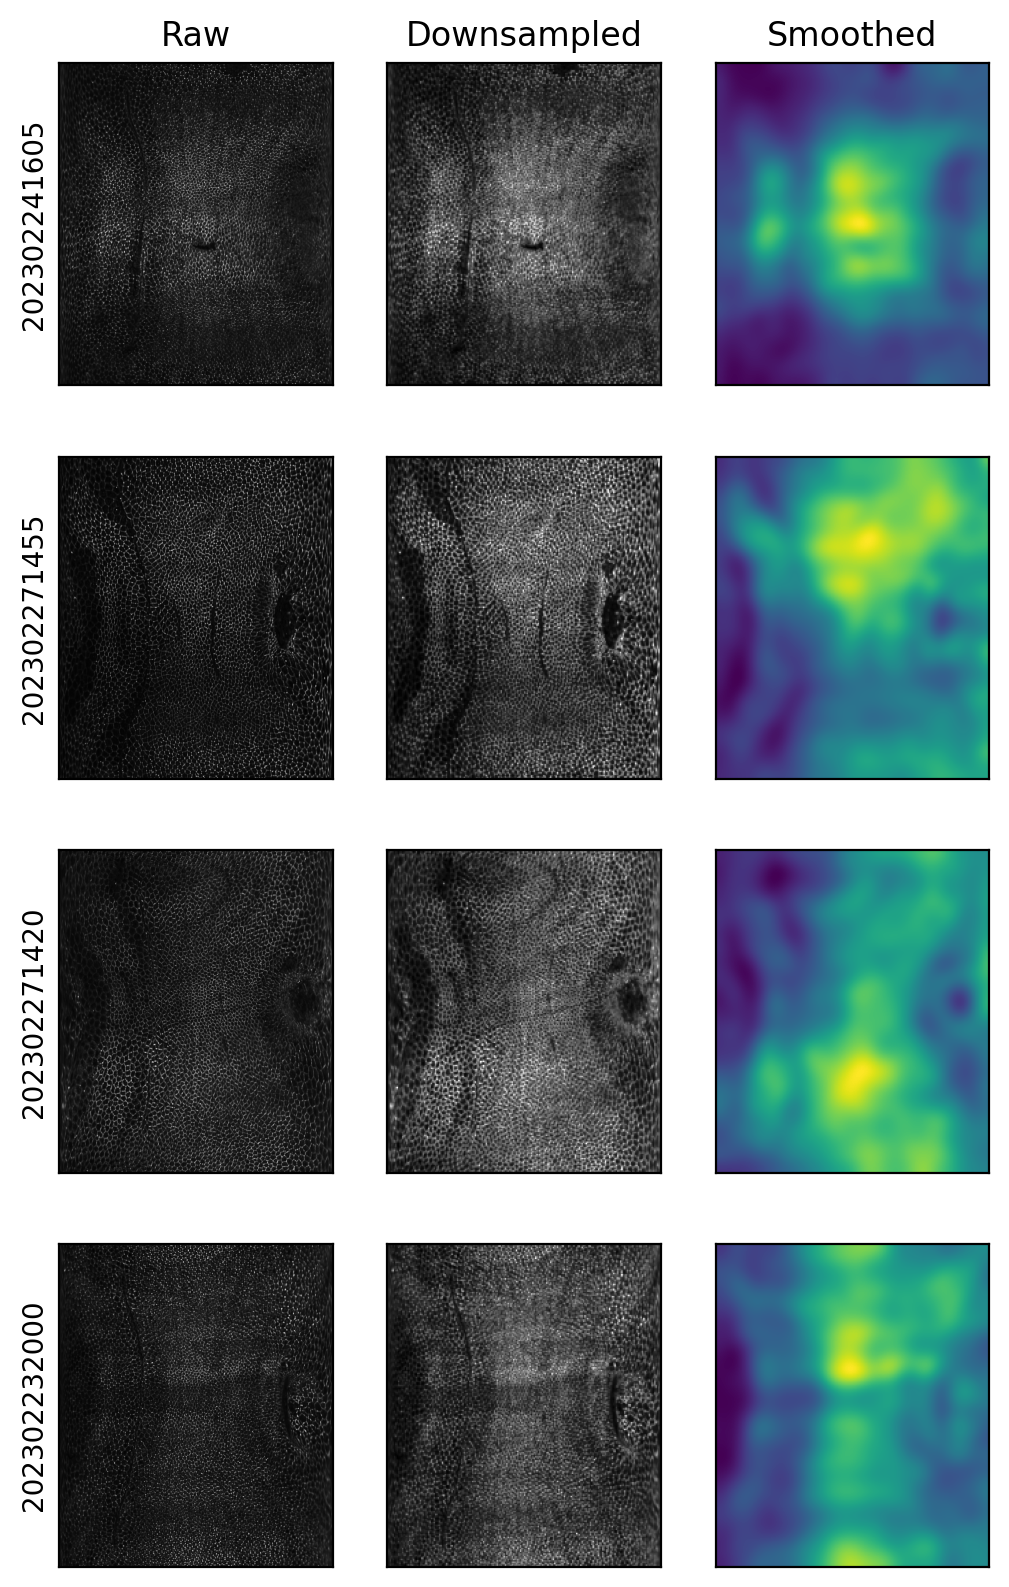

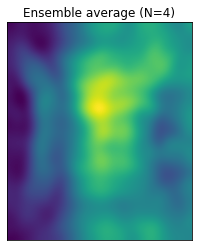

In [60]:
'''
E-cadherin is measured in Eve mutants so use an ensemble average
'''
from utils.plot_utils import *
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.transform import resize


c0 = np.zeros([236, 200])

exclude = ['202302232030', '202302271350', '202302232050']
N = len(glob.glob('Dpp_Mutants/E-cadherin/202*')) - len(exclude)
i = 0

fig, ax = plt.subplots(N, 3, dpi=200, figsize=(6, N*2.5))

for folder in glob.glob('Dpp_Mutants/E-cadherin/202*'):
    if os.path.basename(folder) in exclude: 
        continue    
    filename = glob.glob(f'{folder}/*.tif')[0]
    
    raw = Image.open(filename)
    raw = np.array(raw)
    
    threshold = raw.mean() + 10*raw.std() #Fiduciary bead cutoff
    raw[raw > threshold] = threshold
    
    raw = raw.astype(float)
    raw /= np.median(raw)
    
    proc = resize(raw, [236, 200])
    smooth = gaussian_filter(proc, sigma=7)
    
    print(f'{smooth.min():.3g}, {smooth.max():.3g}, {smooth.mean():.3g}, {smooth.std():.3g}')
    
    color_2D(ax[i, 0], raw, cmap='Greys_r')
    color_2D(ax[i, 1], proc, cmap='Greys_r')
    color_2D(ax[i, 2], smooth, cmap='viridis')
    ax[i, 0].set_ylabel(f'{os.path.basename(folder)}')
    
    c0 += smooth / N
    i += 1
    
ax[0, 0].set_title('Raw')
ax[0, 1].set_title('Downsampled')
ax[0, 2].set_title('Smoothed')

for a in ax.flatten():
    a.set_ylim([dv_min, dv_max])

ax = plt.figure().gca()
color_2D(ax, c0, cmap='viridis')
ax.set_title(f'Ensemble average (N={N})')
ax.set_ylim([dv_min, dv_max])

np.save('Dpp_Mutants/ensemble_c0', c0)

0.447, 3.83, 1.5, 0.642
0.396, 2.59, 1.29, 0.354
0.696, 2.1, 1.17, 0.266


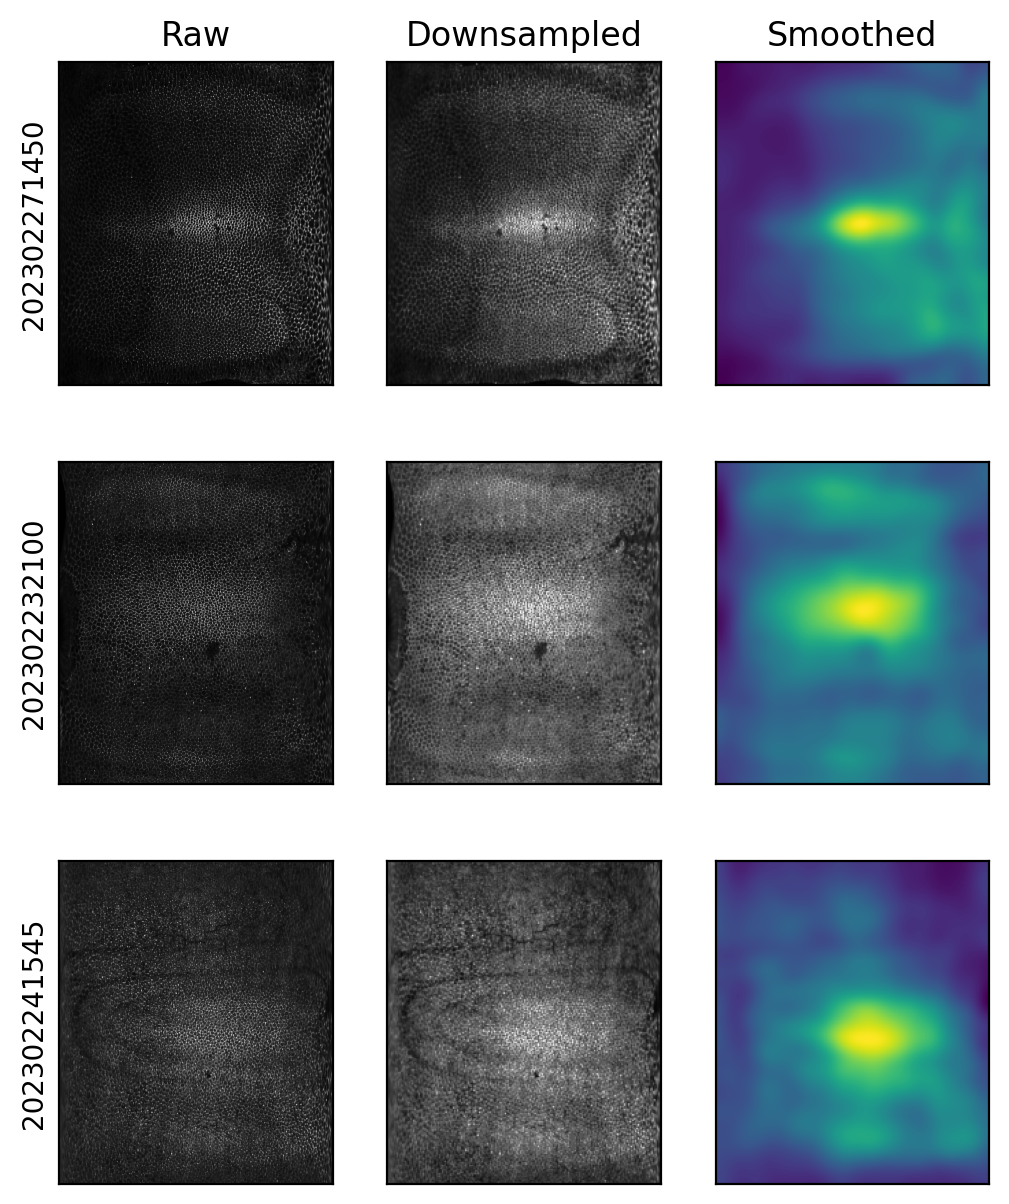

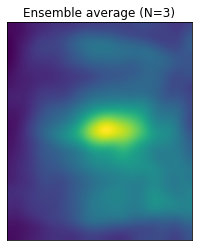

In [61]:
'''
E-cadherin is measured in Eve mutants so use an ensemble average
'''
from utils.plot_utils import *
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.transform import resize


c0 = np.zeros([236, 200])
exclude = ['202302241555']

N = len(glob.glob('Dpp_Controls/E-cadherin/202*')) - len(exclude)
i = 0

fig, ax = plt.subplots(N, 3, dpi=200, figsize=(6, N*2.5))

for folder in glob.glob('Dpp_Controls/E-cadherin/202*'):
    if os.path.basename(folder) in exclude: 
        continue
    filename = glob.glob(f'{folder}/*.tif')[0]
    
    raw = Image.open(filename)
    raw = np.array(raw)
    
    threshold = raw.mean() + 10*raw.std() #Fiduciary bead cutoff
    raw[raw > threshold] = threshold
    
    raw = raw.astype(float)
    raw /= np.median(raw)
    
    proc = resize(raw, [236, 200])
    smooth = gaussian_filter(proc, sigma=7)
    
    print(f'{smooth.min():.3g}, {smooth.max():.3g}, {smooth.mean():.3g}, {smooth.std():.3g}')
    
    color_2D(ax[i, 0], raw, cmap='Greys_r')
    color_2D(ax[i, 1], proc, cmap='Greys_r')
    color_2D(ax[i, 2], smooth, cmap='viridis')
    ax[i, 0].set_ylabel(f'{os.path.basename(folder)}')
    
    c0 += smooth / N
    i += 1
    
ax[0, 0].set_title('Raw')
ax[0, 1].set_title('Downsampled')
ax[0, 2].set_title('Smoothed')

for a in ax.flatten():
    a.set_ylim([dv_min, dv_max])

ax = plt.figure().gca()
color_2D(ax, c0, cmap='viridis')
ax.set_title(f'Ensemble average (N={N})')
ax.set_ylim([dv_min, dv_max])

np.save('Dpp_Controls/ensemble_c0', c0)

Raw data
0.669 2.74 1.32 0.359
0.845 2.16 1.43 0.297
0.841 1.48 1.05 0.145
After rescaling
0.841 1.48 1.04 0.111
0.842 1.25 1.02 0.0916
0.841 1.48 1.05 0.145


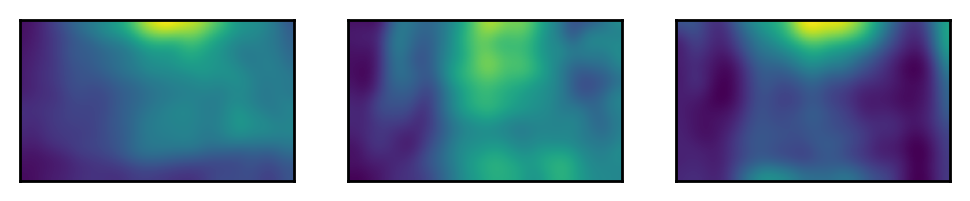

In [3]:
c0 = np.load('Dpp_Controls/ensemble_c0.npy')
c1 = np.load('Dpp_Mutants/ensemble_c0.npy')
c2 = np.load('Twist_Mutants/ensemble_c0.npy')

print('Raw data')

print(f'{c0.min():.3g} {c0.max():.3g} {c0.mean():.3g} {c0.std():.3g}')
print(f'{c1.min():.3g} {c1.max():.3g} {c1.mean():.3g} {c1.std():.3g}')
print(f'{c2.min():.3g} {c2.max():.3g} {c2.mean():.3g} {c2.std():.3g}')

#Find rescaling operation for controls
wt_range_cad = np.ptp(c2)
control_range_cad = np.ptp(c0)

c0 = (c0 - np.min(c0)) * wt_range_cad / control_range_cad + np.min(c2)
c1 = (c1 - np.min(c0)) * wt_range_cad / control_range_cad + np.min(c2)

print('After rescaling')

print(f'{c0.min():.3g} {c0.max():.3g} {c0.mean():.3g} {c0.std():.3g}')
print(f'{c1.min():.3g} {c1.max():.3g} {c1.mean():.3g} {c1.std():.3g}')
print(f'{c2.min():.3g} {c2.max():.3g} {c2.mean():.3g} {c2.std():.3g}')

fig, ax = plt.subplots(1, 3, dpi=200)
color_2D(ax[0], c0)
color_2D(ax[1], c1)
color_2D(ax[2], c2)

## Get ensemble-averaged myosin and flow

In [104]:
t = np.arange(0, 21)

v_dpp_avg = np.zeros([len(t), 2, 236, 200])
m_dpp_avg = np.zeros([len(t), 2, 2, 236, 200])

for i, ti in enumerate(t):
    vi, mi = [], []
    for folder in glob.glob('Dpp_Mutants/Sqh-GFP/202*'):
        eId = os.path.basename(folder)
        v = np.load(f'{folder}/velocity2D.npy', mmap_mode='r')
        m = np.load(f'{folder}/tensor2D.npy', mmap_mode='r')
        
        t0 = np.arange(len(v)) - offsets_dpp[eId]      
        mask = np.abs(t0 - ti) < 1
                        
        vi.append(v[mask])
        mi.append(m[mask])
    
    v_dpp_avg[i] = np.mean(np.concatenate(vi, axis=0), axis=0)
    m_dpp_avg[i] = np.mean(np.concatenate(mi, axis=0), axis=0)

np.save('Dpp_Mutants/ensemble_v0', v_dpp_avg)
np.save('Dpp_Mutants/ensemble_m0', m_dpp_avg)
np.save('Dpp_Mutants/ensemble_t0', t)

print(v_dpp_avg.shape, m_dpp_avg.shape, t.shape)

(21, 2, 236, 200) (21, 2, 2, 236, 200) (21,)


In [105]:
t = np.arange(0, 21)

v_dpp_avg = np.zeros([len(t), 2, 236, 200])
m_dpp_avg = np.zeros([len(t), 2, 2, 236, 200])

for i, ti in enumerate(t):
    vi, mi = [], []
    for folder in glob.glob('Dpp_Controls/Sqh-GFP/202*'):
        eId = os.path.basename(folder)
        v = np.load(f'{folder}/velocity2D.npy', mmap_mode='r')
        m = np.load(f'{folder}/tensor2D.npy', mmap_mode='r')
        
        t0 = np.arange(len(v)) - offsets_dpp[eId]      
        mask = np.abs(t0 - ti) < 1
                        
        vi.append(v[mask])
        mi.append(m[mask])
    
    v_dpp_avg[i] = np.mean(np.concatenate(vi, axis=0), axis=0)
    m_dpp_avg[i] = np.mean(np.concatenate(mi, axis=0), axis=0)

np.save('Dpp_Controls/ensemble_v0', v_dpp_avg)
np.save('Dpp_Controls/ensemble_m0', m_dpp_avg)
np.save('Dpp_Controls/ensemble_t0', t)

print(v_dpp_avg.shape, m_dpp_avg.shape, t.shape)

(21, 2, 236, 200) (21, 2, 2, 236, 200) (21,)


Raw data
2.37e-08 0.0593 0.0122 0.0155
2.87e-08 0.0583 0.0122 0.0155
7.12e-08 0.15 0.0257 0.0357
After rescaling
5.99e-08 0.15 0.0307 0.0392
7.24e-08 0.147 0.0308 0.039
7.12e-08 0.15 0.0257 0.0357


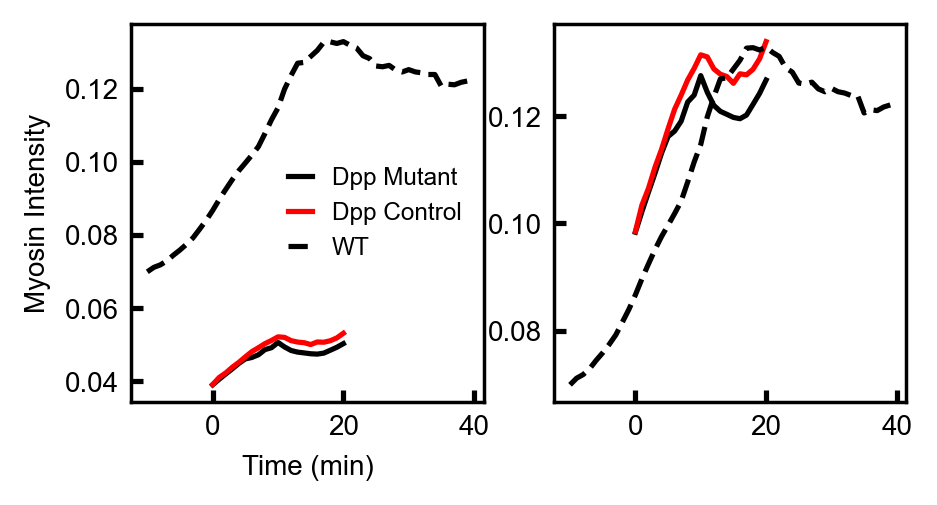

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))

m0 = np.load('Dpp_Controls/ensemble_m0.npy')
t0 = np.load('Dpp_Controls/ensemble_t0.npy')

m1 = np.load('Dpp_Mutants/ensemble_m0.npy')
t1 = np.load('Dpp_Mutants/ensemble_t0.npy')

m2 = np.load('../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble/tensor2D.npy')
t2 = np.load('../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble/t.npy')

ax[0].plot(t0, np.linalg.norm(m0, axis=(1, 2)).mean(axis=(1, 2)), color='black', label='Dpp Mutant')
ax[0].plot(t1, np.linalg.norm(m1, axis=(1, 2)).mean(axis=(1, 2)), color='red', label='Dpp Control')
ax[0].plot(t2, np.linalg.norm(m2, axis=(1, 2)).mean(axis=(1, 2)), color='black', linestyle='--', label='WT')
ax[0].set_ylabel('Myosin Intensity')
ax[0].set_xlabel('Time (min)')
ax[0].legend()

print('Raw data')

m00 = np.linalg.norm(m0[t0 == 0], axis=0)
m11 = np.linalg.norm(m1[t1 == 0], axis=0)
m22 = np.linalg.norm(m2[t2 == 0], axis=0)
print(f'{m00.min():.3g} {m00.max():.3g} {m00.mean():.3g} {m00.std():.3g}')
print(f'{m11.min():.3g} {m11.max():.3g} {m11.mean():.3g} {m11.std():.3g}')
print(f'{m22.min():.3g} {m22.max():.3g} {m22.mean():.3g} {m22.std():.3g}')

#Find rescaling operation for controls
wt_range_myo = np.ptp(m22)
control_range_myo = np.ptp(m00)

m0 = m0 * wt_range_myo / control_range_myo
m1 = m1 * wt_range_myo / control_range_myo

print('After rescaling')

m00 = np.linalg.norm(m0[t0 == 0], axis=0)
m11 = np.linalg.norm(m1[t1 == 0], axis=0)
m22 = np.linalg.norm(m2[t2 == 0], axis=0)
print(f'{m00.min():.3g} {m00.max():.3g} {m00.mean():.3g} {m00.std():.3g}')
print(f'{m11.min():.3g} {m11.max():.3g} {m11.mean():.3g} {m11.std():.3g}')
print(f'{m22.min():.3g} {m22.max():.3g} {m22.mean():.3g} {m22.std():.3g}')


ax[1].plot(t0, np.linalg.norm(m0, axis=(1, 2)).mean(axis=(1, 2)), color='black')
ax[1].plot(t1, np.linalg.norm(m1, axis=(1, 2)).mean(axis=(1, 2)), color='red')
ax[1].plot(t2, np.linalg.norm(m2, axis=(1, 2)).mean(axis=(1, 2)), color='black', linestyle='--')


## Fly closed loop

Rescaling by  2.5225571682589076
Calibrating flow model to movie intensity
Initializing
Using torchdiffeq solver


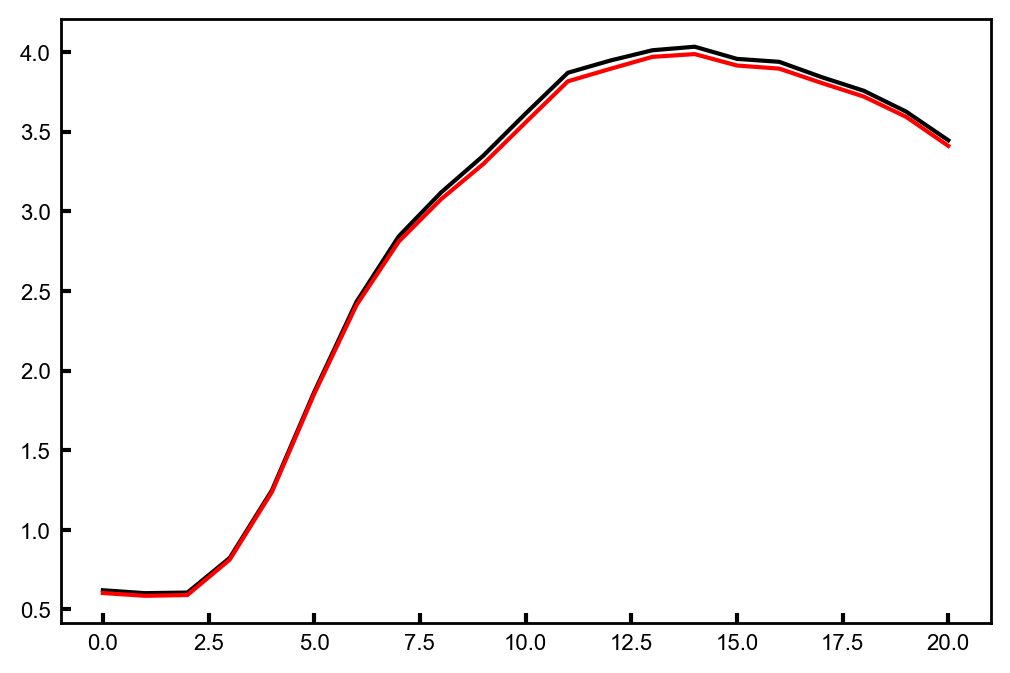

In [7]:
import torch
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils.forecasting.closed_loop import ClosedFlyLoop
from utils.forecasting.plot_utils import *
from utils.vae.convnext_models import MaskedVAE_Evolver, VAE
from utils.decomposition.decomposition_model import LeftRightSymmetrize

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
info = torch.load('../../tb_logs/May2023/forecasting_vae_v3.ckpt') #Works well with sigma = 3


vae = MaskedVAE_Evolver(**info['hparams'])
vae.load_state_dict(info['state_dict'])
vae = vae.double().to(device).eval();

#Collect initial conditions - m, v, and time
folder = 'Dpp_Controls'
t0 = np.load(f'{folder}/ensemble_t0.npy')
v0 = np.load(f'{folder}/ensemble_v0.npy')
c0 = np.load(f'{folder}/ensemble_c0.npy')
m0 = np.load(f'{folder}/ensemble_m0.npy')

c0 = (c0 - np.min(c0)) * wt_range_cad / control_range_cad + np.min(c2)
m0 = m0 * wt_range_myo / control_range_myo

print('Rescaling by ', wt_range_myo / control_range_myo)
    
#Calibrate flow strength
print('Calibrating flow model to movie intensity')
y0 = m0.reshape([-1, 4, 236, 200])
v1 = VAE.forward(vae, torch.from_numpy(y0).to(device))[0].cpu().detach().numpy()

scaler0 = MinMaxScaler().fit(np.linalg.norm(v0, axis=1).mean(axis=(1, 2))[:, None])
scaler1 = MinMaxScaler().fit(np.linalg.norm(v1, axis=1).mean(axis=(1, 2))[:, None])

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    v = VAE.forward(vae, y)[0]
    
    vnorm = torch.linalg.norm(v, dim=1).mean(dim=(1, 2))
    vscale = vnorm * scaler1.scale_[0] + scaler1.min_[0] #Norm via a min-max scaler [0, 1]
    vscale = (vscale - scaler0.min_[0]) / scaler0.scale_[0] #Norm on the calibrated domain
    
    vscale = vscale / vnorm
    
    v = v * vscale[:, None, None, None]
    return v

from scipy.interpolate import interp1d
v_int = interp1d(t0, v0, axis=0)
def v_model(t, y):
    v = v_int(t.cpu().numpy())
    return torch.from_numpy(v).to(device)

y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    c0.reshape([1, *c0.shape[-2:]]),
])    
y0 = torch.from_numpy(y0)
model = ClosedFlyLoop(v_model, sigma=5)
model.fit(y0[None])

m1, c1, v1 = model.integrate(y0.to(device), t0)

fig, ax = plt.subplots(1, 1, dpi=200)
ax.plot(t0, np.linalg.norm(v0, axis=1).mean(axis=(1, 2)), color='black')
ax.plot(t0, np.linalg.norm(v1, axis=1).mean(axis=(1, 2)), color='red')

np.save(f'{folder}/forecasted_m', m1)
np.save(f'{folder}/forecasted_v', v1)

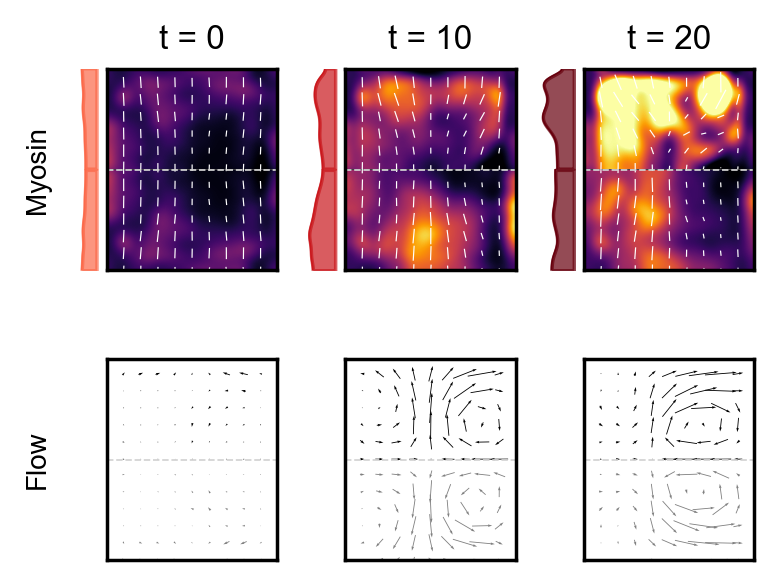

In [8]:
time = t0
mask = np.s_[..., 15:-15, 15:-15]

inputs  = [m1, v1]
targets = [m0, v0]
labels = ['Myosin', 'Flow']
colors = ['Reds', 'Greys']
dt = 10

N = int(np.ceil(len(time) / dt))
n_rows = 2
fig, ax = plt.subplots(n_rows, N, 
                       figsize=(N, n_rows*1.2),
                       constrained_layout=True)

vfc = 40
skip = 20
midpoint = 118
slc = np.s_[..., ::skip, ::skip]
ylim = [dv_min, dv_max]
xlim = [ap_min, ap_max]


top = np.s_[..., midpoint:, :]
bot = np.s_[..., :midpoint, :]
vwargs = dict(pivot='middle', width=0.005)

dv = np.linspace(dv_min, dv_min+(dv_max-dv_min)/2, midpoint)

mask_in = np.zeros([236, 200])
mask_tg = np.zeros([236, 200])
mask_in[top] = 1
mask_tg[bot] = 1

X = np.linspace(ap_min, ap_max, 200)
Y = np.linspace(dv_min, dv_max, 236)
Y, X = np.meshgrid(Y, X, indexing='ij')


for i, (label, z, z0) in enumerate(zip(labels, inputs, targets)):
    znorm = z0.reshape([z0.shape[0], -1, *z0.shape[-2:]])
    n_channels = znorm.shape[1]
    znorm = np.linalg.norm(znorm[mask], axis=1)[..., :-20] #ignore posterior pole
    kwargs = dict(vmin=np.min(znorm), vmax=np.max(znorm))

    axes = []
    cmap = plt.get_cmap(colors[i])
    for j in range(N):
        jj = dt * j
        if i == 0:
            ax[i, j].set_title(f't = {time[jj]:.0f}')

        color = cmap((time[jj] + 20) / (time.max() + 20))

        if n_channels == 1:
            color_2D(ax[i, j], z[jj, ::-1], alpha=mask_in, **kwargs)
            color_2D(ax[i, j], z0[jj], alpha=mask_tg, **kwargs)
        elif n_channels == 4:
            zj = z[jj, :, :, ::-1].copy()
            zj[0, 1] *= -1 #Because we're inverting it
            zj[1, 0] *= -1 #Because we're inverting it
            plot_tensor2D(ax[i, j], zj * np.sign(mask_in), alpha=mask_in, **kwargs)
            plot_tensor2D(ax[i, j], z0[jj] * np.sign(mask_tg), alpha=mask_tg, **kwargs)
        elif n_channels == 2:
            vwargs['scale'] = 5e1
            ax[i, j].quiver(X[bot][slc], Y[bot][slc],
                            z0[jj, 1][bot][slc], z0[jj, 0][bot][slc],
                            color='grey', **vwargs)
            ax[i, j].quiver(X[top][slc], Y[top][slc],
                            z[jj, 1, ::-1][top][slc], -z[jj, 0, ::-1][top][slc],
                            color='black', **vwargs)

        ax[i, j].set(xlim=xlim, ylim=ylim, xticks=[], yticks=[], aspect=1)
        ax[i, j].axhline(dv_min + 0.5*(dv_max-dv_min), lw=0.5, color='lightgrey', linestyle='--')
        
        if i == n_rows - 1:
            continue
            
        cut = get_cut(z[jj, ..., ::-1, :])
        cut0 = get_cut(z0[jj])

        cut = cut[midpoint:]
        cut0 = cut0[:midpoint]
        ax_Y = ax[i, j].inset_axes([-0.25, 0, 0.2, 1], sharey=ax[i, j])
        ax_Y.plot(cut, dv+dv_midpoint, color=color, lw=0.5)
        ax_Y.fill_betweenx(dv+dv_midpoint, 0, cut, color=color, alpha=0.7)
        ax_Y.plot(cut0, dv, color=color, lw=0.5)
        ax_Y.fill_betweenx(dv, 0, cut0, color=color, alpha=0.7)
        axes.append(ax_Y)
        
        for axis in axes:
            xl = axes[-1].get_xlim()
            axis.set_xlim(xl)
            axis.invert_xaxis()
            axis.axis('off')

    ax[i, 0].set_ylabel(label, labelpad=16)